In [352]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import tqdm
import pickle
from matplotlib.patches import Ellipse

# Part I : Classification: K-means, and the EM algorithm

In [353]:
def EM_diag(n_cluster,
       dataset,
       theta='kmeans',
      max_iter=1000):
    """
    Implementation of EM diagonal.
    
    D_0[j]: vector of size d (D is then np.diag(D))
    """
    d=2
    n = dataset.shape[0]
    if theta == 'kmeans':
        kmeans = KMeans(n_clusters=n_cluster).fit(dataset)
        mu = kmeans.cluster_centers_
    else:
        mu = [np.random.uniform(-5,5,(d,)) for i in range(n_cluster)]
    p = np.random.uniform(0,1,(n_cluster,))
    p/=np.sum(p)
    D = [3*np.ones((d,)) for i in range(n_cluster)]
    tau = np.zeros((n,n_cluster))
    t=0
    
    for t in tqdm.tqdm_notebook(range(max_iter)):
        #E step
        for i in range(n):
            p_xi = 0
            for k in range(n_cluster):
                tau[i,k] = p[k]*multivariate_normal(mu[k],np.diag(D[k])).pdf(dataset[i])
                p_xi += tau[i,k]
            tau[i,:] /= p_xi
        #M step
        sum_tau_i = np.sum(tau, axis=0)
        for j in range(n_cluster):
            mu[j] = tau[:,j].dot(dataset) / sum_tau_i[j]
            p[j] = sum_tau_i[j]/n
            x_mu_j = np.square(dataset-mu[j])
            D[j] = tau[:,j].dot(x_mu_j) / sum_tau_i[j]
    predictions = np.argmax(tau, axis=1)
    return  p, mu, D, tau, predictions

In [354]:
def run_EM_diag(list_k,pair_X):
    results = dict()
    for k in list_k:
        print(f"k={k}")
        results[k] = []
        for X in pair_X:
            p,mu,D,tau, diag_pred= EM_diag(n_cluster=k, dataset=X,max_iter=2000)
            results[k] += [p,mu,D,tau,diag_pred]
        #pickle.dump(results,open(f'./EM_diag_res_k-{k}.p','wb'))
    pickle.dump(results,open(f'./EM_diag_res.p','wb'))
    return results
#EM_diag_results = run_EM_diag([2,3,4],pair_X)
EM_diag_results = pickle.load(open('./EM_diag_res.p','rb'))

In [356]:
def predictions_sklearn(k, X):
    kmeans = KMeans(n_clusters=k).fit(X)
    
    em_gmm = GaussianMixture(n_components=k).fit(X)
    em_gmm_lab = em_gmm.predict(X)
    
    #em_gmm_diag = GaussianMixture(n_components=k,covariance_type='diag').fit(X)
    #em_gmm_diag_lab = em_gmm_diag.predict(X)
    
    #p,mu,D,tau, diag_pred= EM_diag(n_cluster=k, dataset=X,max_iter=1000)
    return kmeans.labels_, em_gmm_lab#, em_gmm_diag_lab, diag_pred

In [357]:
def plot_pred(ax,predictions,n_label, X, title=None):
    for label in range(n_label):
        idx = (predictions==label)
        ax.plot(X[idx,0],X[idx,1],color_label[label],label=f'class {label}')
    ax.legend()
    if title:
        ax.set_title(title)
        
def plot_pred_ellipse(fig,ax,predictions,list_mu,list_cov,n_label,
                      X, title=None):
    for label in range(n_label):
        idx = (predictions==label)
        ax.plot(X[idx,0],X[idx,1],color_label[label],label=f'class {label}')
        mean = list_mu[label]
        #print(list_cov[label])
        if title == 'EM diag':
            cov = np.diag(list_cov[label])
        else:
            cov = list_cov[label]
        plot_ellipse(mean,cov,fig,ax,0.95,color[label])
    ax.legend()
    if title:
        ax.set_title(title)

In [378]:
def plot_ellipse(mean,cov_mat,fig,ax,p=0.95,colorf='r'):
    s=-2*np.log(1-p)
    eigval, eigvec = np.linalg.eig(cov_mat)
    idx_maj = np.argmax(eigval)
    idx_min = np.argmin(eigval)
    maj_axis = s*np.sqrt(eigval[idx_maj])
    min_axis = s*np.sqrt(eigval[idx_min])

    alpha = np.arctan(eigvec[:,idx_maj][1]/eigvec[:,idx_maj][0])
    e = Ellipse(xy=mean, width=maj_axis,height=min_axis,angle=alpha*180/np.pi,
               edgecolor=colorf,fill=0,facecolor=colorf)
    ax.add_patch(e)
    ax.plot(mean[0],mean[1],'mo')
    
    
def plot_fig(k,pair_X, EM_diag_results,idx_pair_X):
    
    n_pair = len(idx_pair_X)
    EM_results_k = EM_diag_results[k]
    
    new_pair_X = []
    for i in idx_pair_X:
        new_pair_X.append(pair_X[i])
    
    
    fig, axes = plt.subplots(3,n_pair,figsize=(40,30) )
    for id_pair,X in enumerate(new_pair_X):
        # kmeans
        kmeans = KMeans(n_clusters=k).fit(X)
        ax = axes[0,id_pair]
        plot_pred(ax,kmeans.labels_,k,X,'kmeans')
        
        # EM_GMM full
        ax = axes[1,id_pair]
        em_gmm = GaussianMixture(n_components=k).fit(X)
        em_gmm_lab = em_gmm.predict(X)
        list_mu = em_gmm.means_
        list_cov = em_gmm.covariances_
        plot_pred_ellipse(fig,ax,em_gmm_lab,list_mu,list_cov,k,X,'EM full')
        
        # EM diag
        ax = axes[2,id_pair]
        diag_pred = EM_results_k[idx_pair_X[id_pair]*5+4]
        list_mu = EM_results_k[idx_pair_X[id_pair]*5+1]
        list_cov = EM_results_k[idx_pair_X[id_pair]*5+2]
        
        plot_pred_ellipse(fig,ax,diag_pred,list_mu,list_cov,k,X,'EM diag')

In [ ]:
def pred_plot(k,X):
    fig, axes = plt.subplots(1,3,figsize=(40,10) )
    # kmeans
    kmeans = KMeans(n_clusters=k).fit(X)
    ax = axes[0]
    plot_pred(ax,kmeans.labels_,k,X,'kmeans')

    # EM_GMM full
    ax = axes[1]
    em_gmm = GaussianMixture(n_components=k).fit(X)
    em_gmm_lab = em_gmm.predict(X)
    list_mu = em_gmm.means_
    list_cov = em_gmm.covariances_
    plot_pred_ellipse(fig,ax,em_gmm_lab,list_mu,list_cov,k,X,'EM full')

    # EM diag
    ax = axes[2]
    p, list_mu, list_cov, tau, diag_pred = EM_diag(n_cluster=k,
       dataset=X,
       theta='kmeans',
      max_iter=100)

    plot_pred_ellipse(fig,ax,diag_pred,list_mu,list_cov,k,X,'EM diag')

## Comparison of Kmeans, EM full, EM diagonal

### Iris dataset

In [359]:
# Load data
iris = datasets.load_iris()
pair_X = [] # list of dataset for each pair of dimensions
for i in range(4):
    for j in range(i+1,4):
        pair_X.append(iris.data[:,[i,j]])
y = iris.target

K = [2,3,4]
algos = ['kmeans', 'EM_GMM', 'EM_diag']
color_label = ['r*','b*','g*','y*']
color = ['r','b','g','y']

/home/cindy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


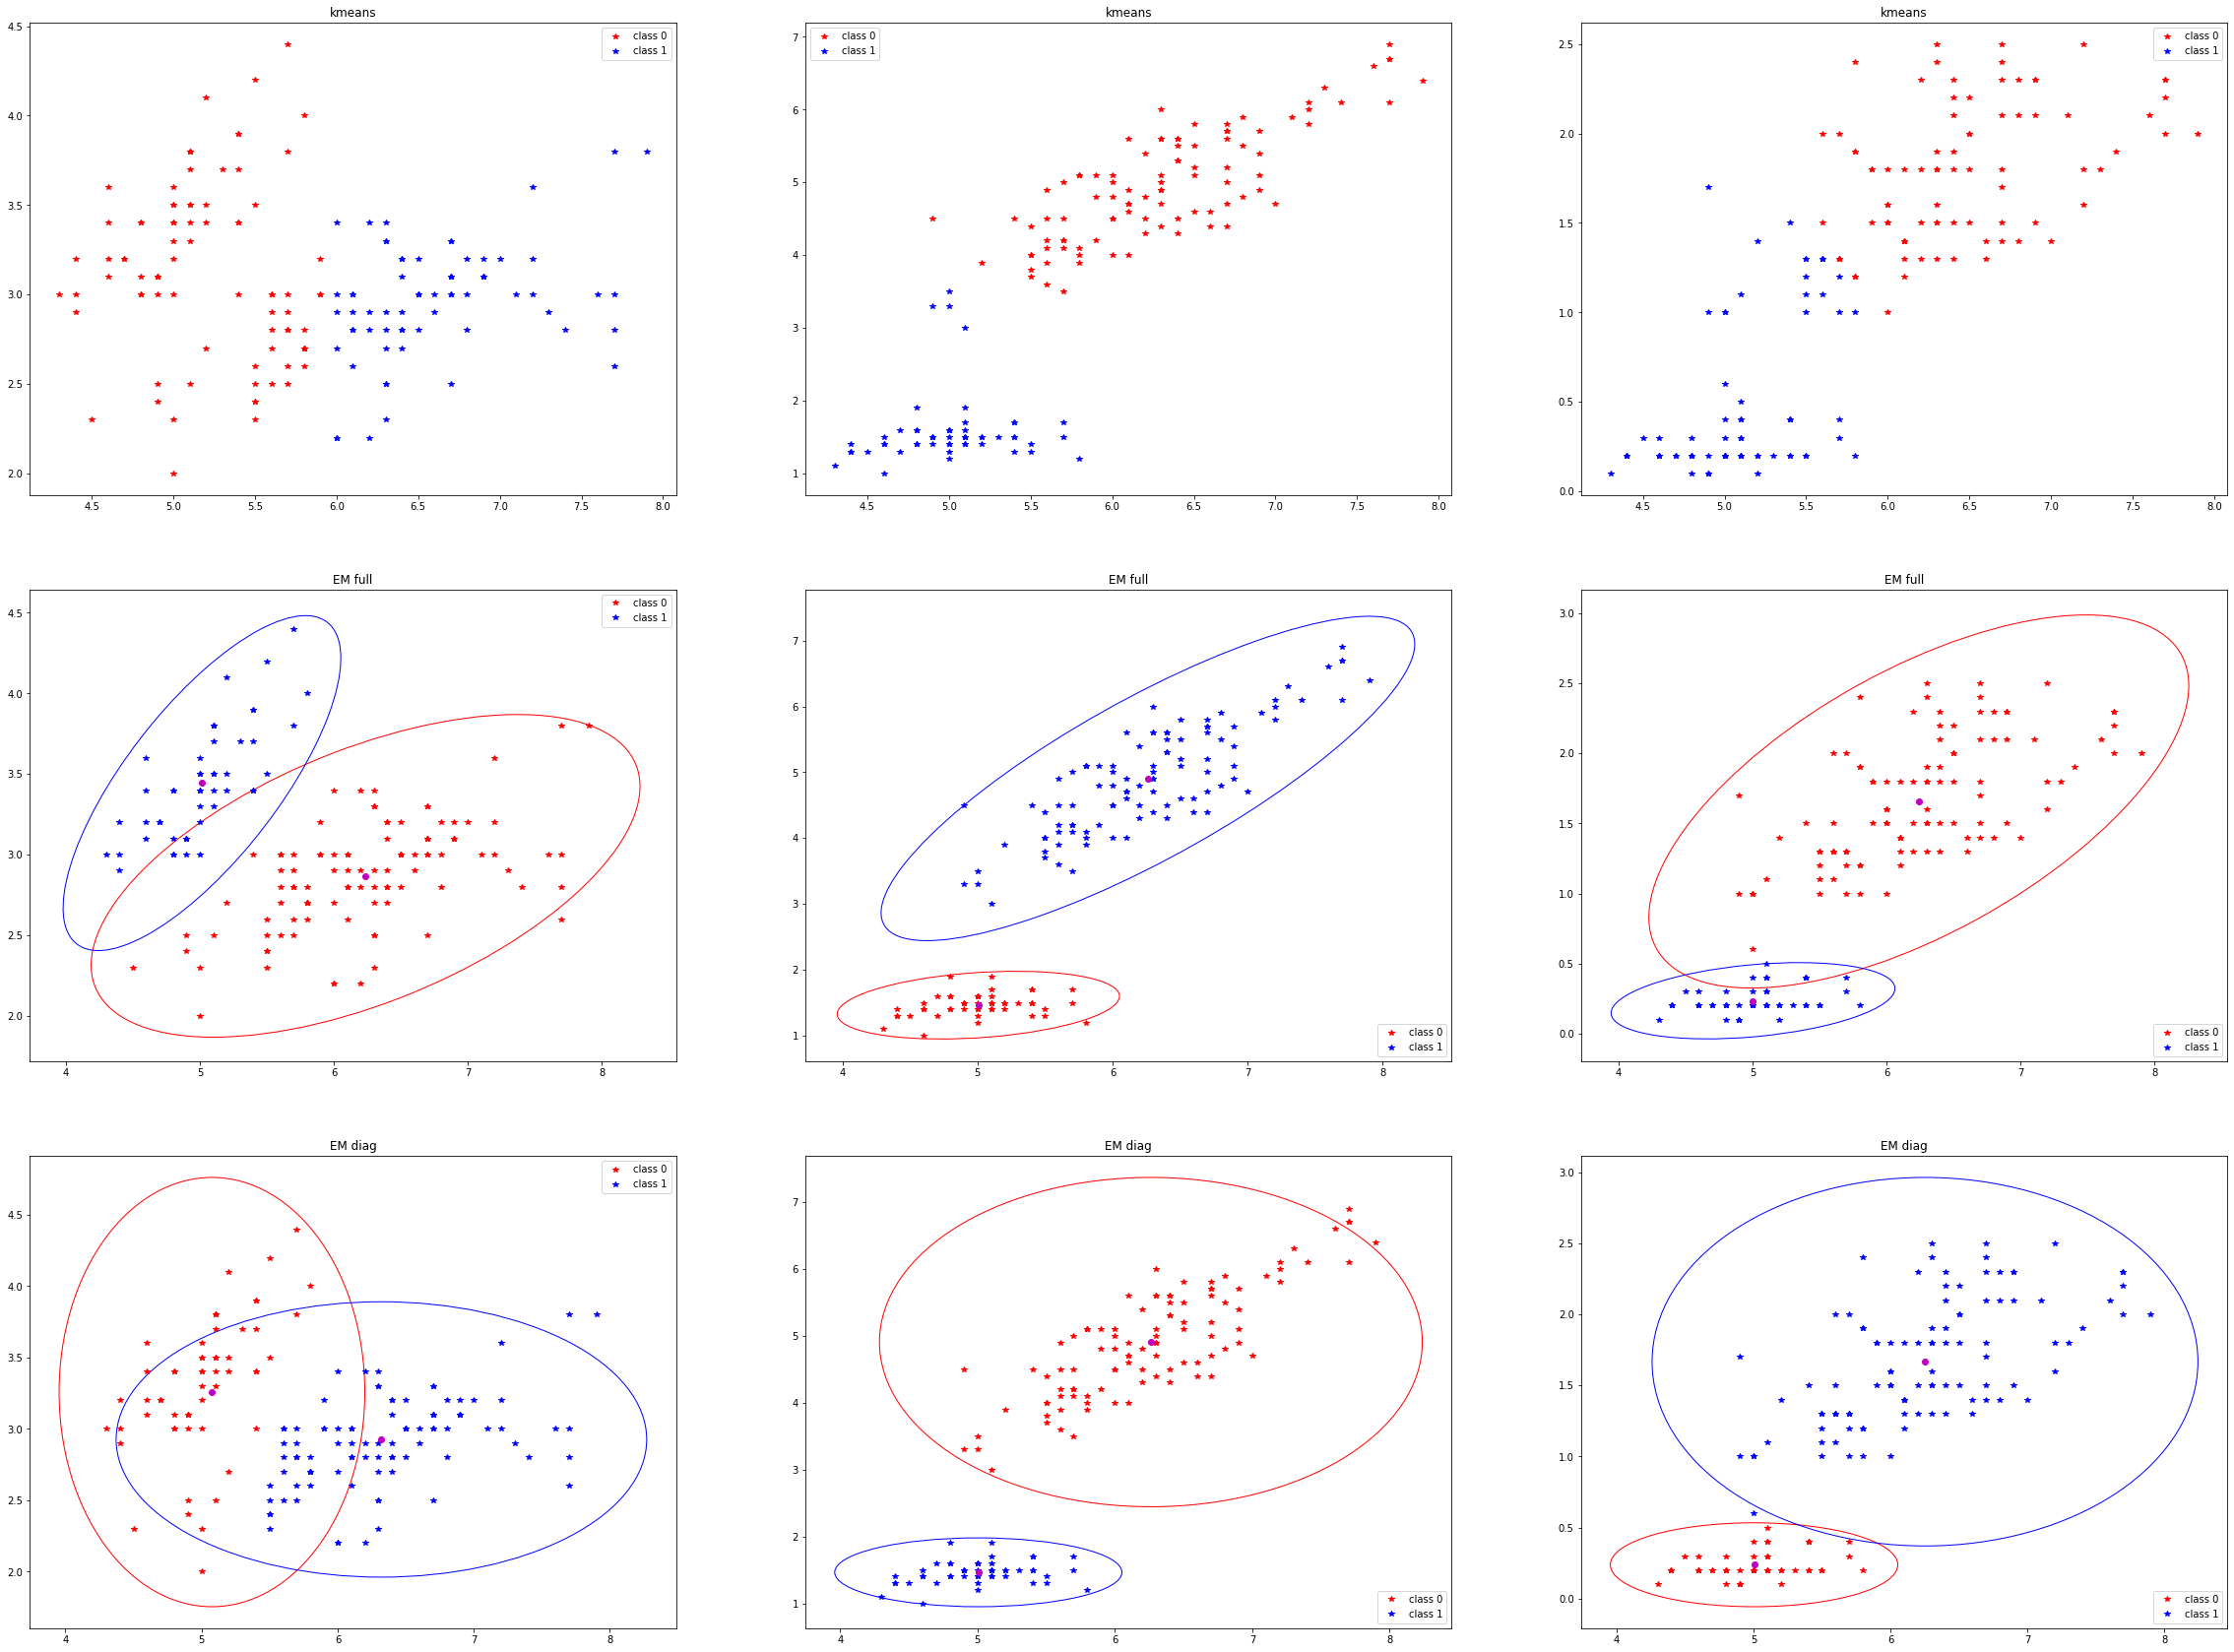

In [372]:
k=2
plot_fig(k,pair_X,EM_diag_results,[0,1,2])
#plt.savefig('./all_k2.eps',format='eps')

/home/cindy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


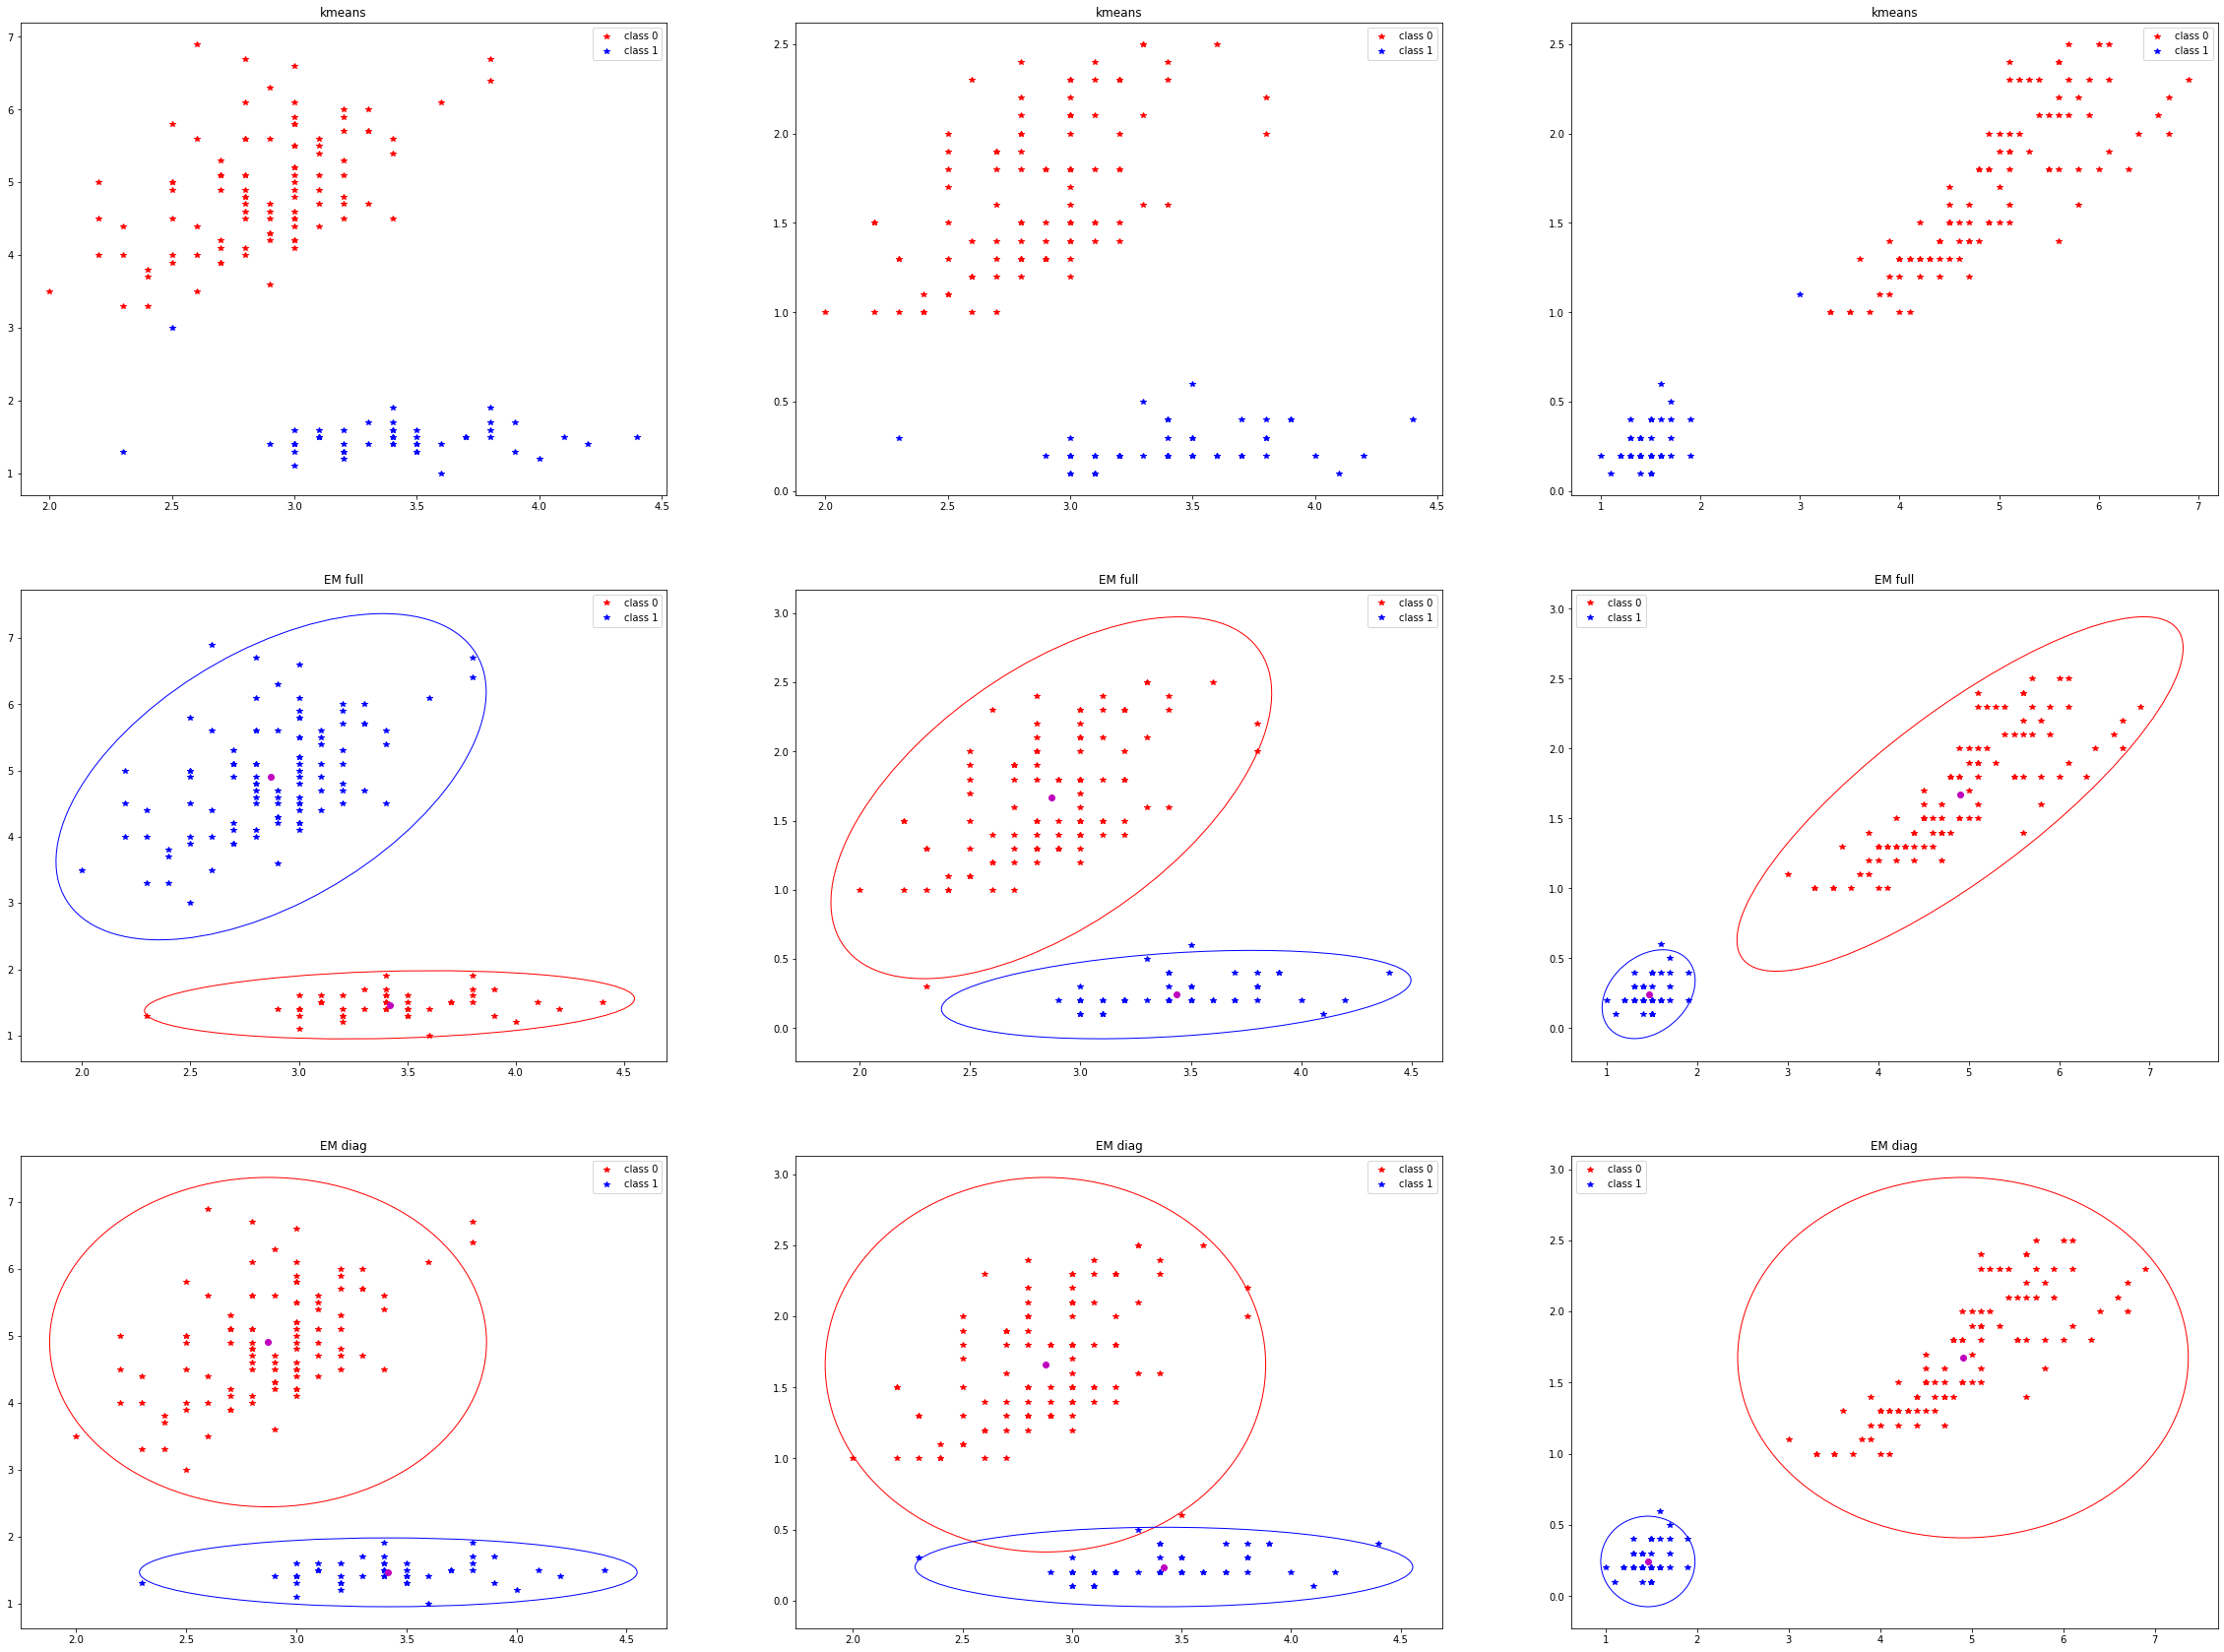

In [361]:
k=2
plot_fig(k,pair_X,EM_diag_results,[3,4,5])

/home/cindy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


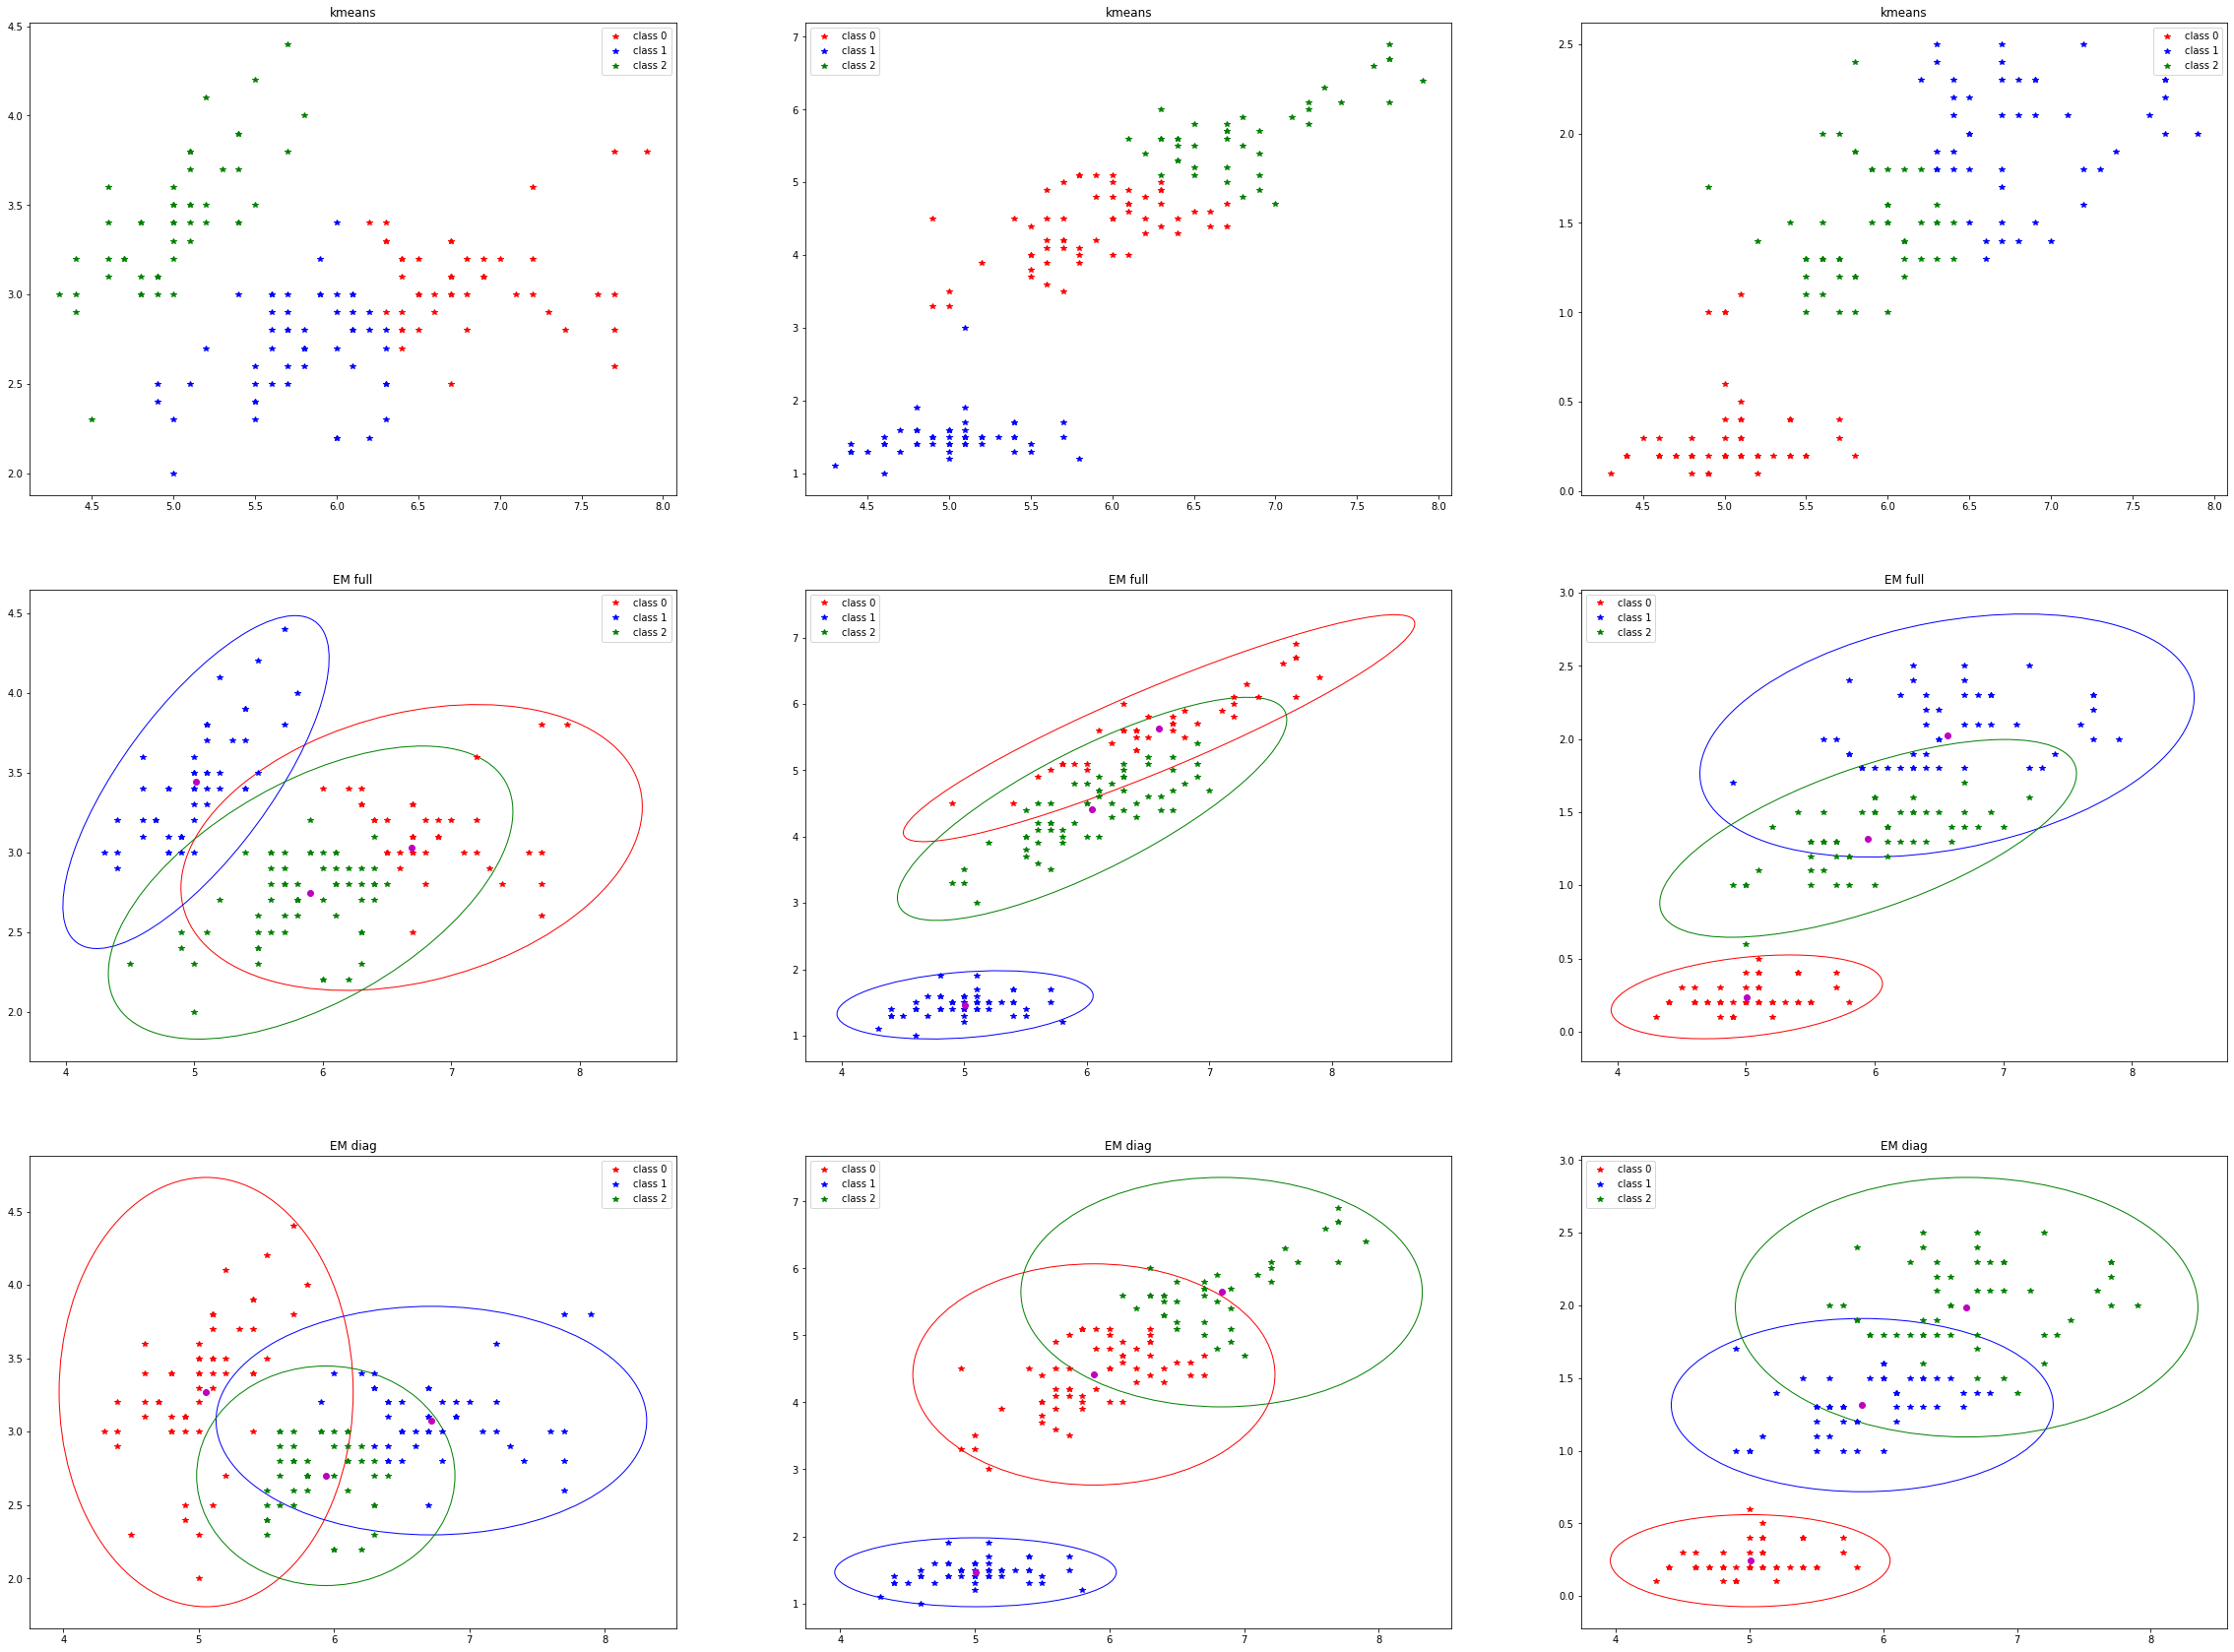

In [370]:
k=3
plot_fig(k,pair_X,EM_diag_results,[0,1,2])
#plt.savefig('./all_k3.eps',format='eps')

/home/cindy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


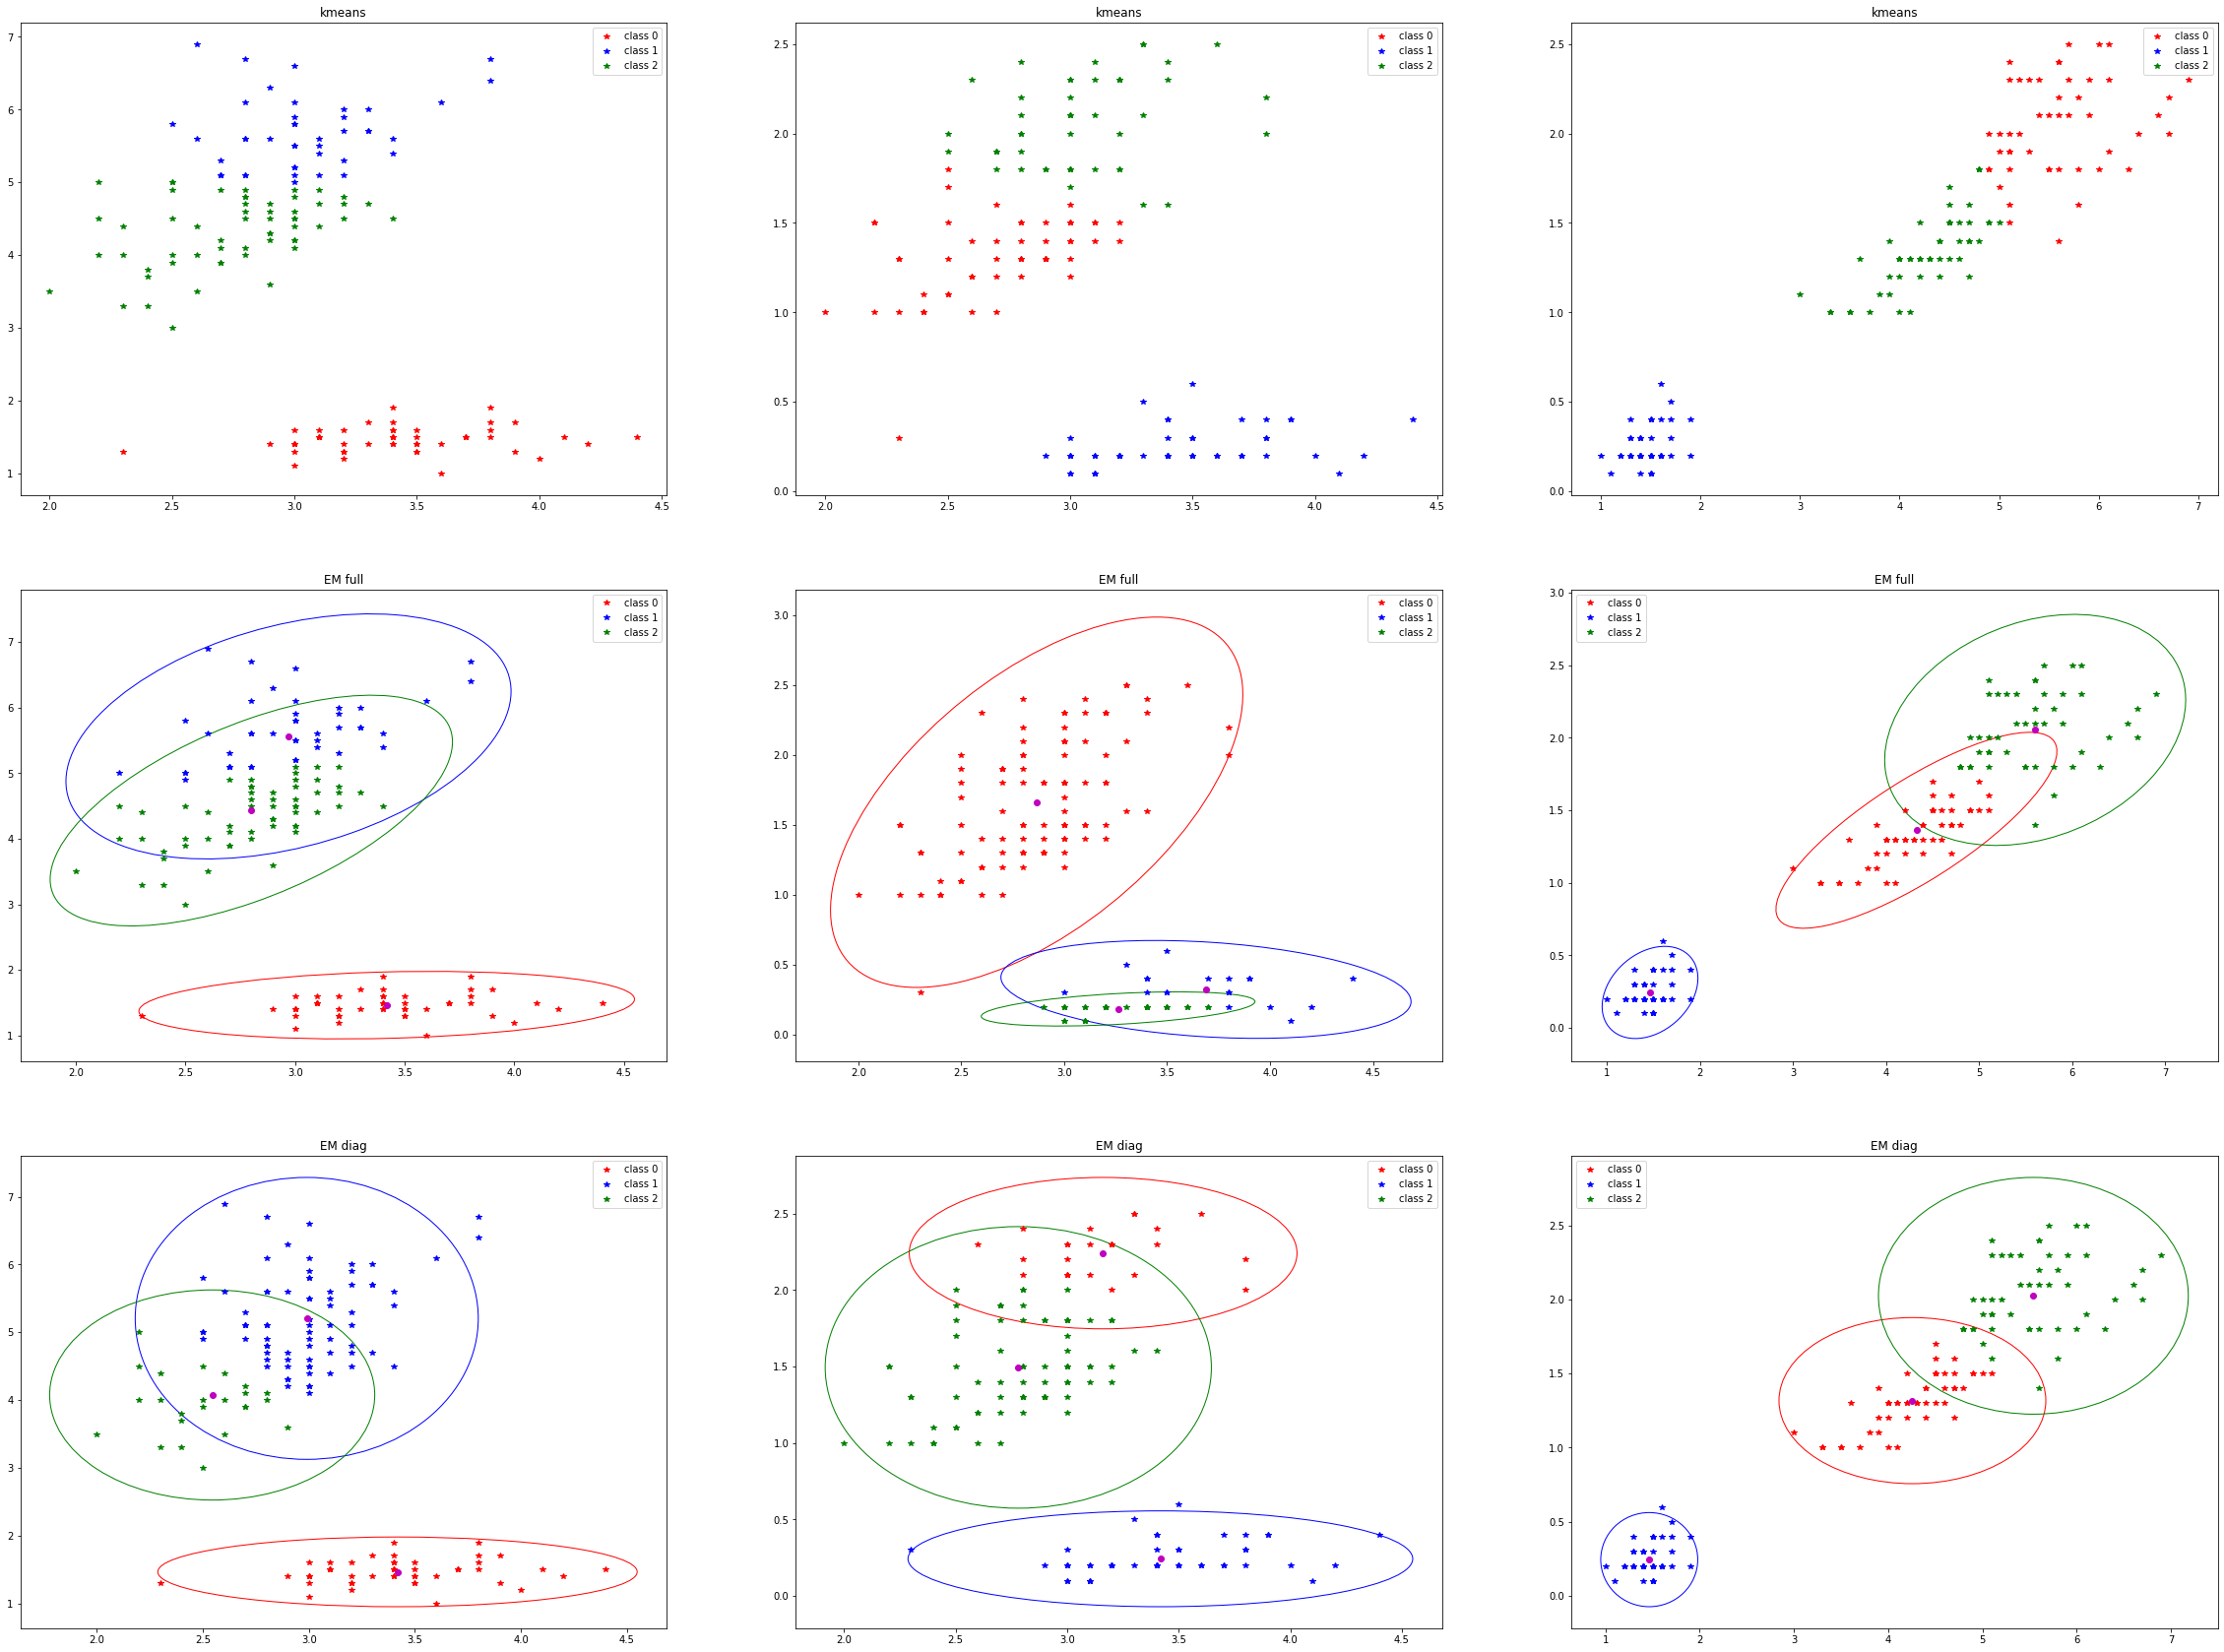

In [363]:
k=3
plot_fig(k,pair_X,EM_diag_results,[3,4,5])

/home/cindy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


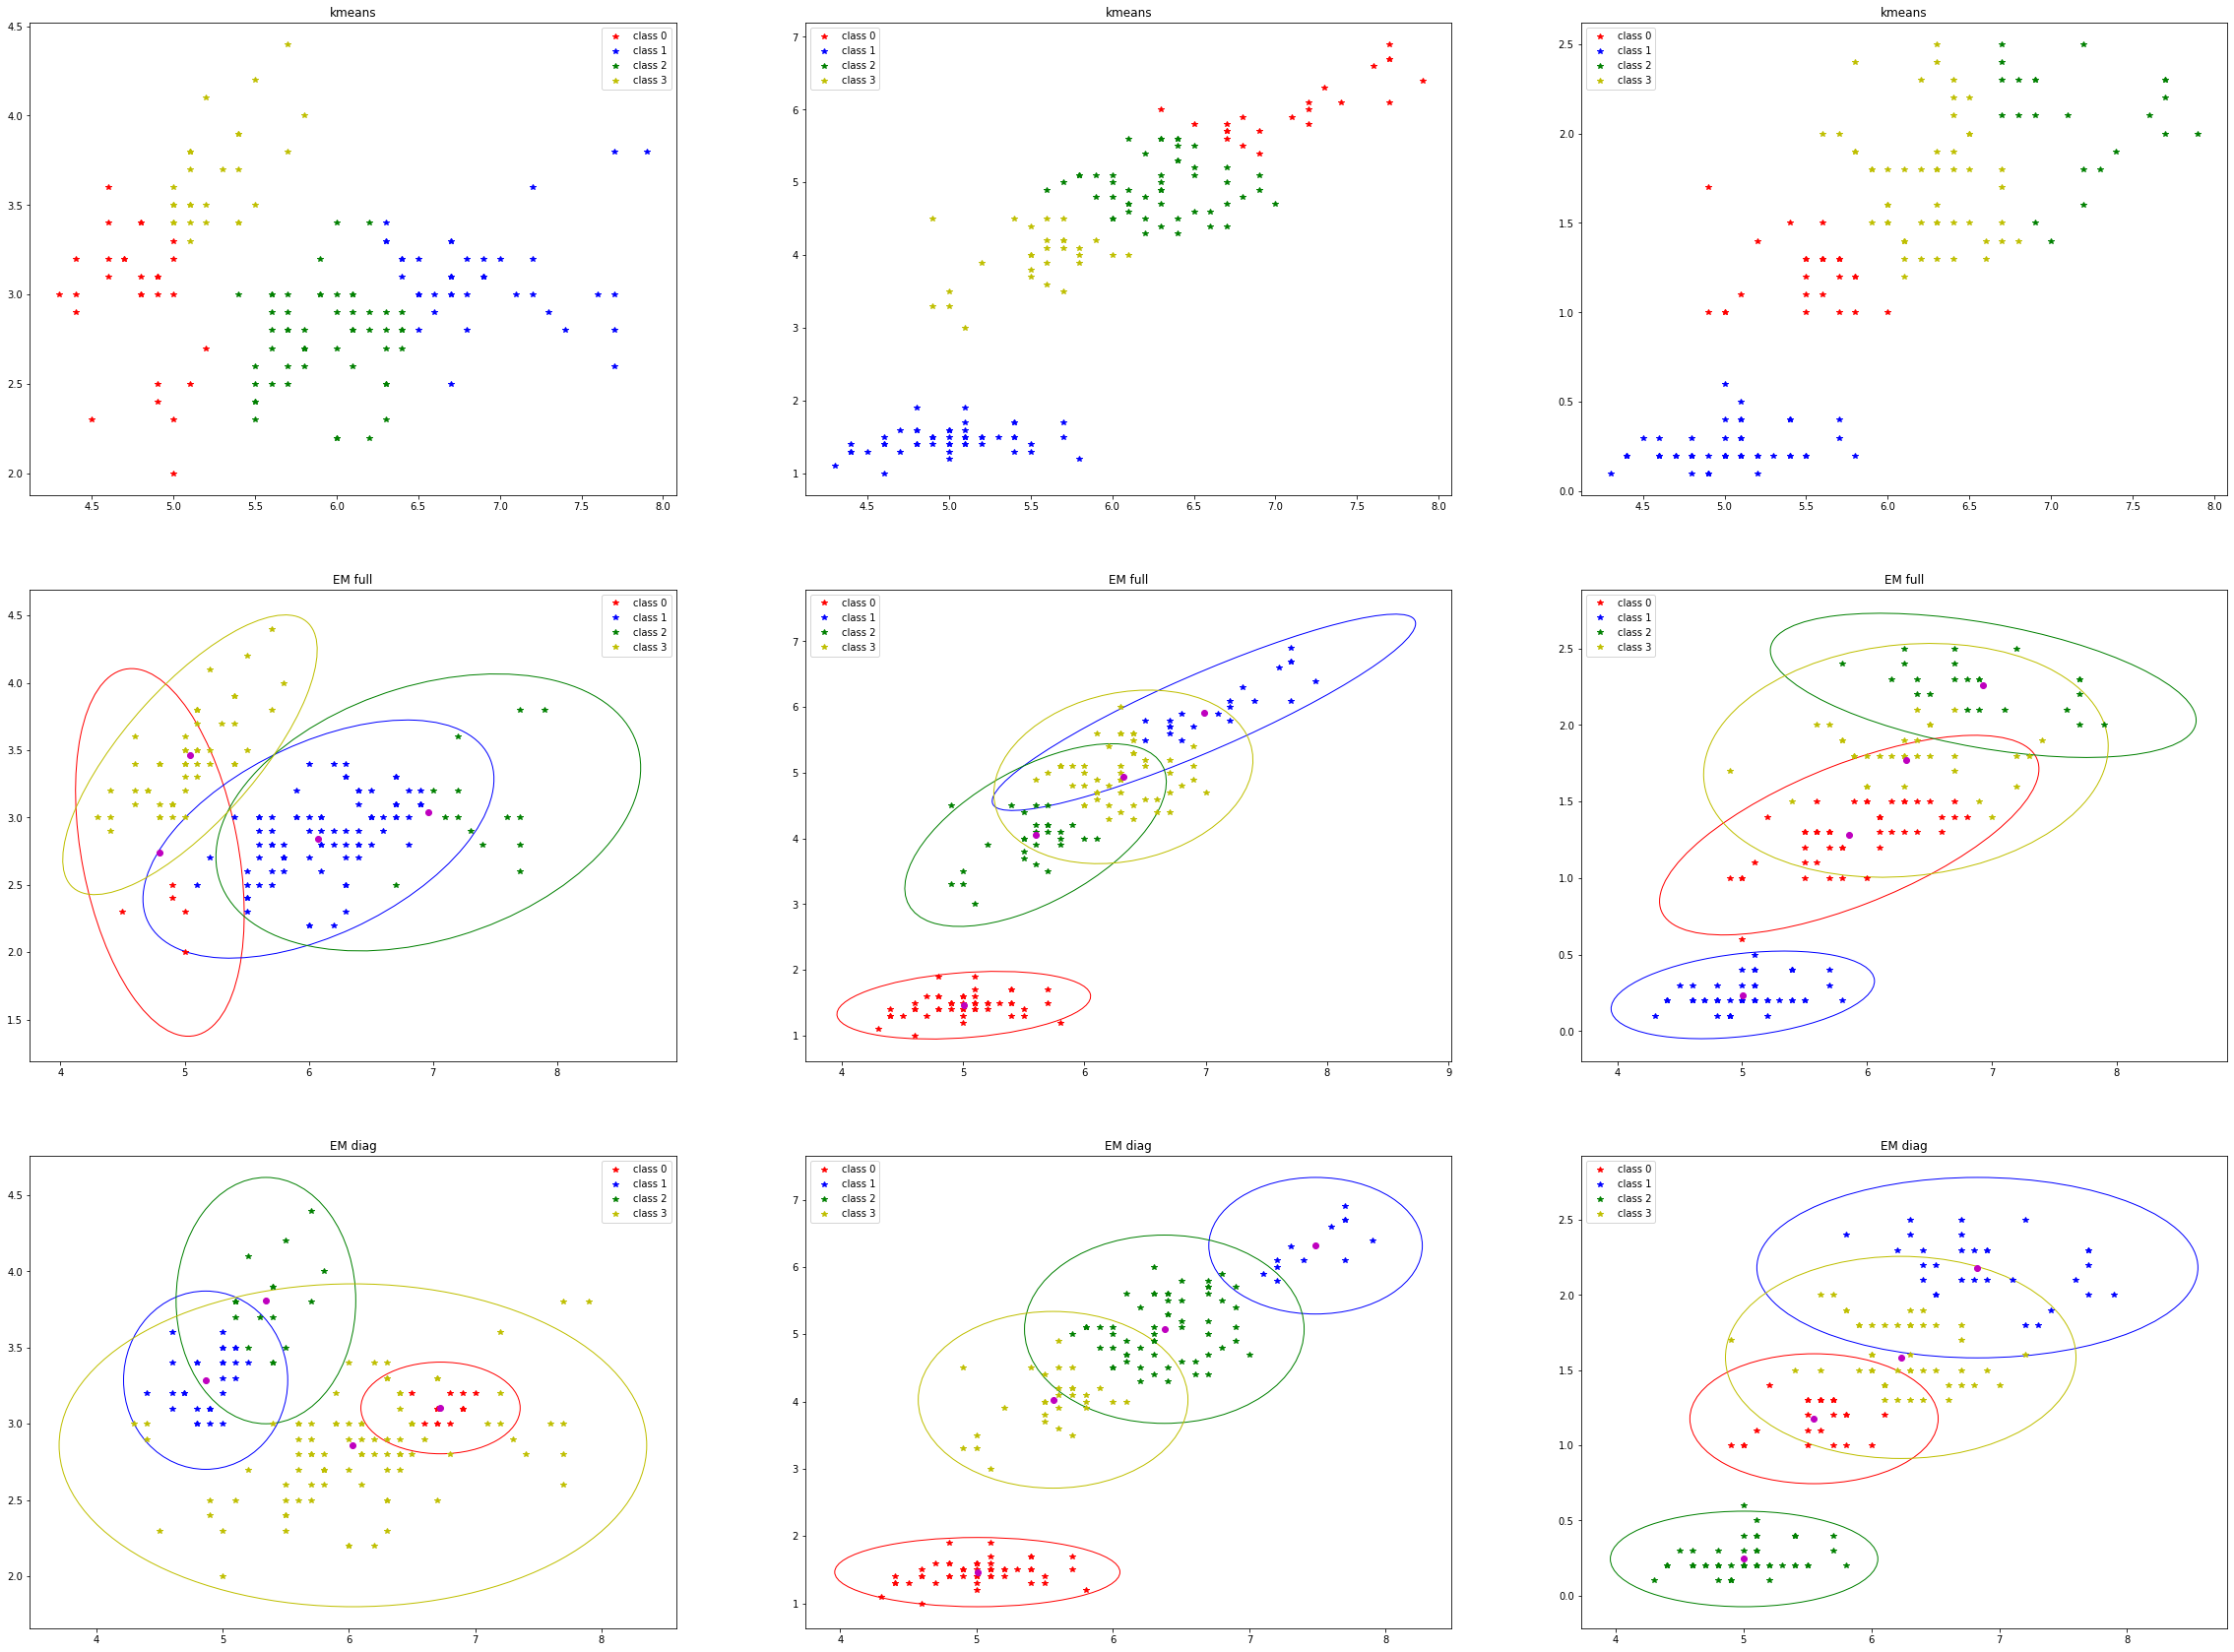

In [364]:
k=4
plot_fig(k,pair_X,EM_diag_results,[0,1,2])

/home/cindy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


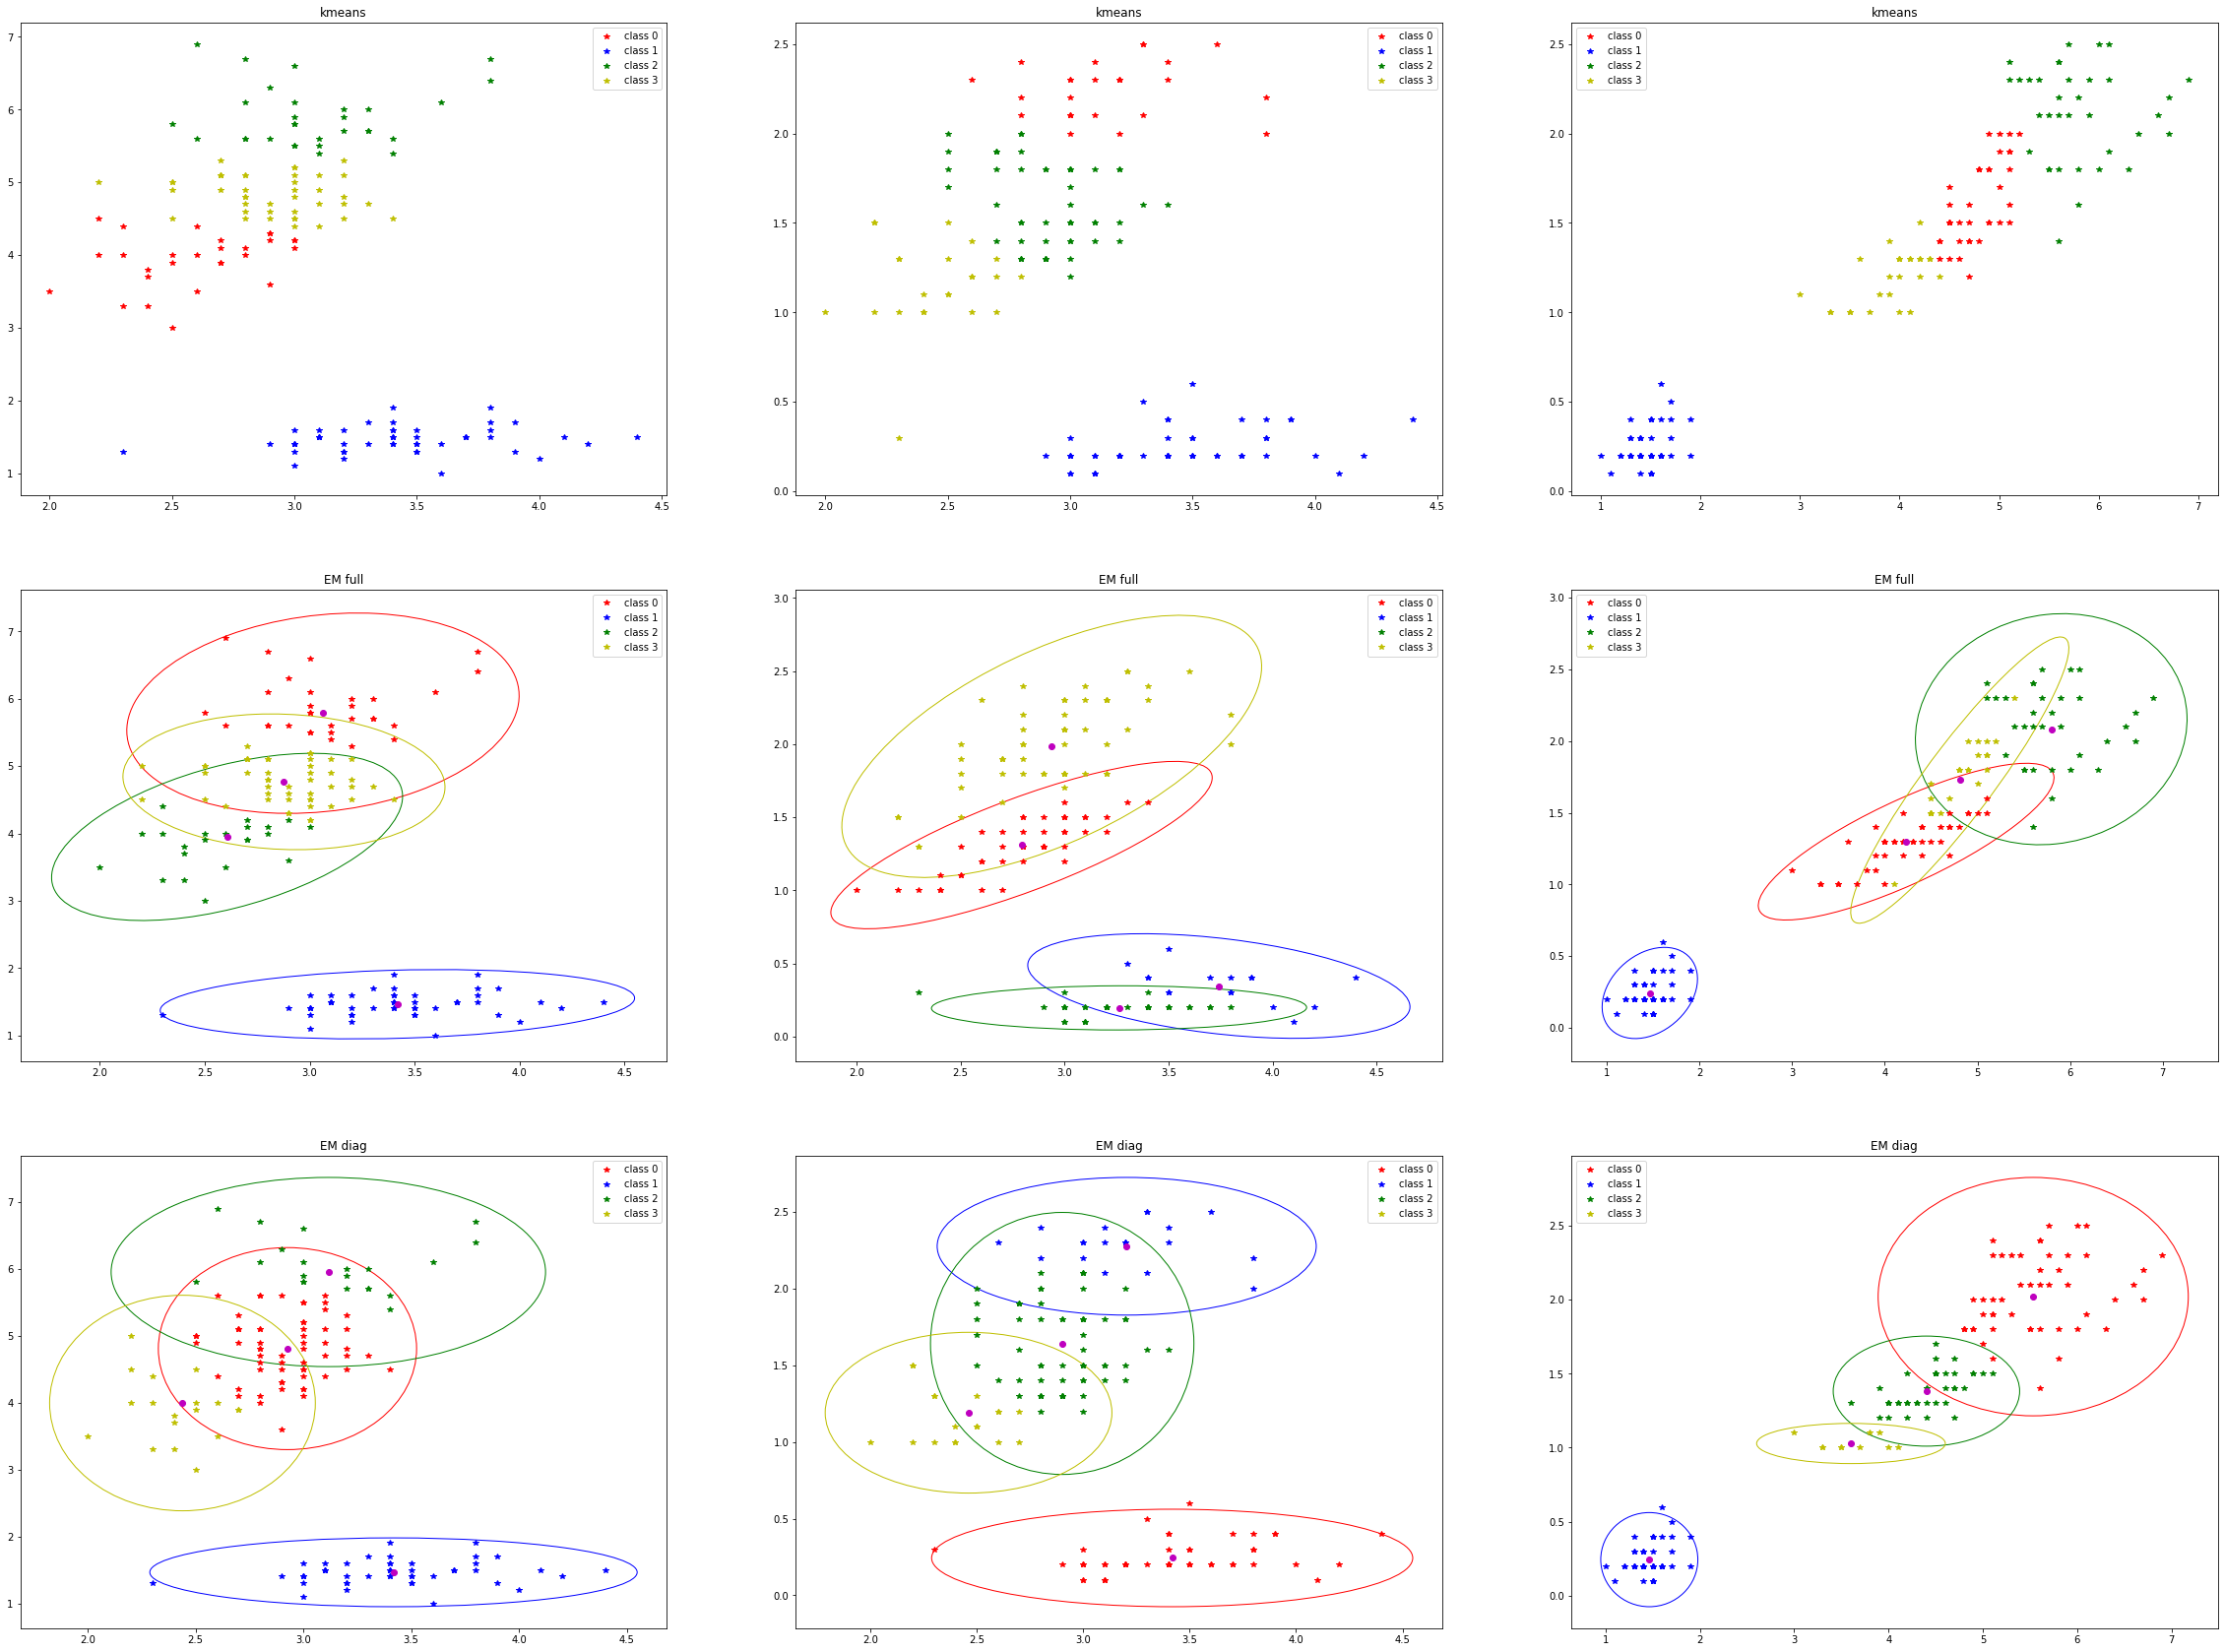

In [368]:
k=4
plot_fig(k,pair_X,EM_diag_results,[3,4,5])
#plt.savefig('./all_k4.eps',format='eps')

### Synthetic dataset

#### 1st case: EM full outperforms EM diag which outperforms Kmeans

In [428]:
mu = [[3,3],[0,5]]
cov = [np.array([[10,2.5],
                 [2.5,1]]),
       np.array([[1,0],
                 [0,1]])]
n_cluster = len(mu)
w,v = np.linalg.eig(cov[0])

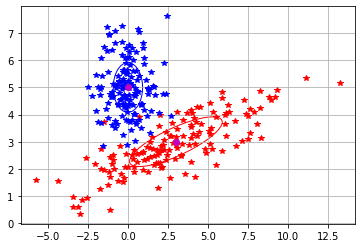

In [432]:
nb_points = 300
dataset = np.zeros((nb_points,2))
fig,ax1 = plt.subplots()
for i in range(n_cluster):
    data = np.random.multivariate_normal(mu[i],cov[i], (nb_points//n_cluster,))
    dataset[i*nb_points//n_cluster:(i+1)*(nb_points//n_cluster)] = data
    ax1.plot(data[:,0],data[:,1],color_label[i])
    plot_ellipse(mu[i],cov[i],fig,ax1,p=0.6,colorf=color[i])
plt.savefig('./synthetic1dataset.eps',format='eps')
plt.grid()

/home/cindy/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


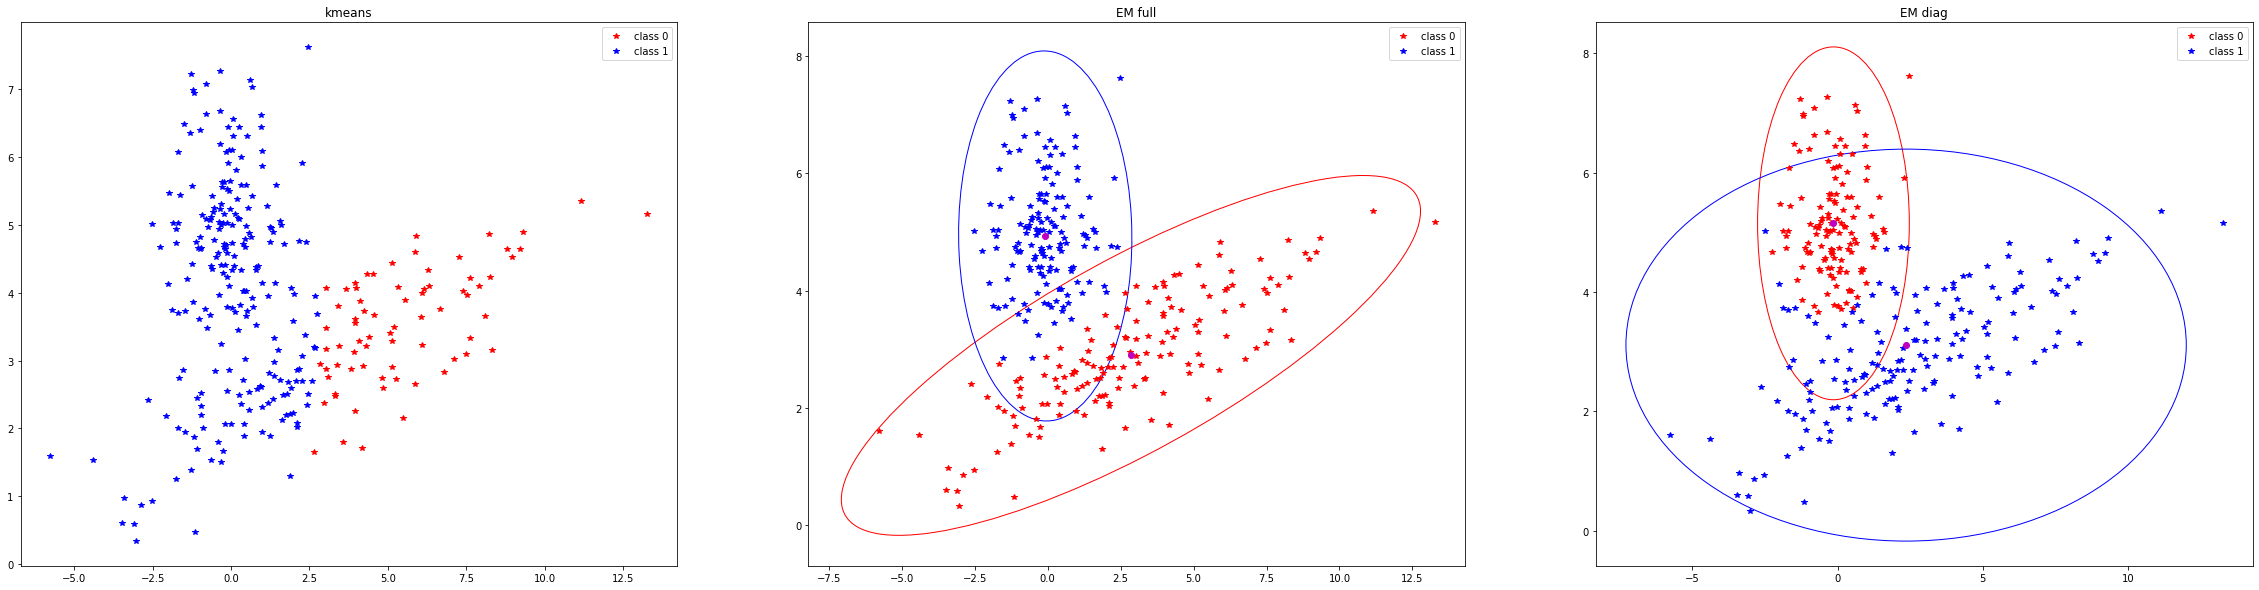

In [433]:
pred_plot(2,dataset)
plt.savefig('./synthetic1pred.eps',format='eps')

#### 2nd case: EM outperforms Kmeans

In [414]:
mu = [[3,3],[3,3]]
cov = [np.array([[10,0],
                 [0,1]]),
       np.array([[1,0],
                 [0,1]])]
n_cluster = len(mu)


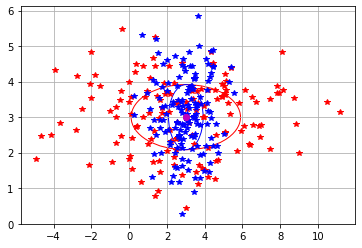

In [426]:
nb_points = 300
dataset = np.zeros((nb_points,2))
fig,ax1 = plt.subplots()
for i in range(n_cluster):
    data = np.random.multivariate_normal(mu[i],cov[i], (nb_points//n_cluster,))
    dataset[i*nb_points//n_cluster:(i+1)*(nb_points//n_cluster)] = data
    ax1.plot(data[:,0],data[:,1],color_label[i])
    plot_ellipse(mu[i],cov[i],fig,ax1,p=0.6,colorf=color[i])
plt.savefig('./synthetic2dataset.eps',format='eps')
plt.grid()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


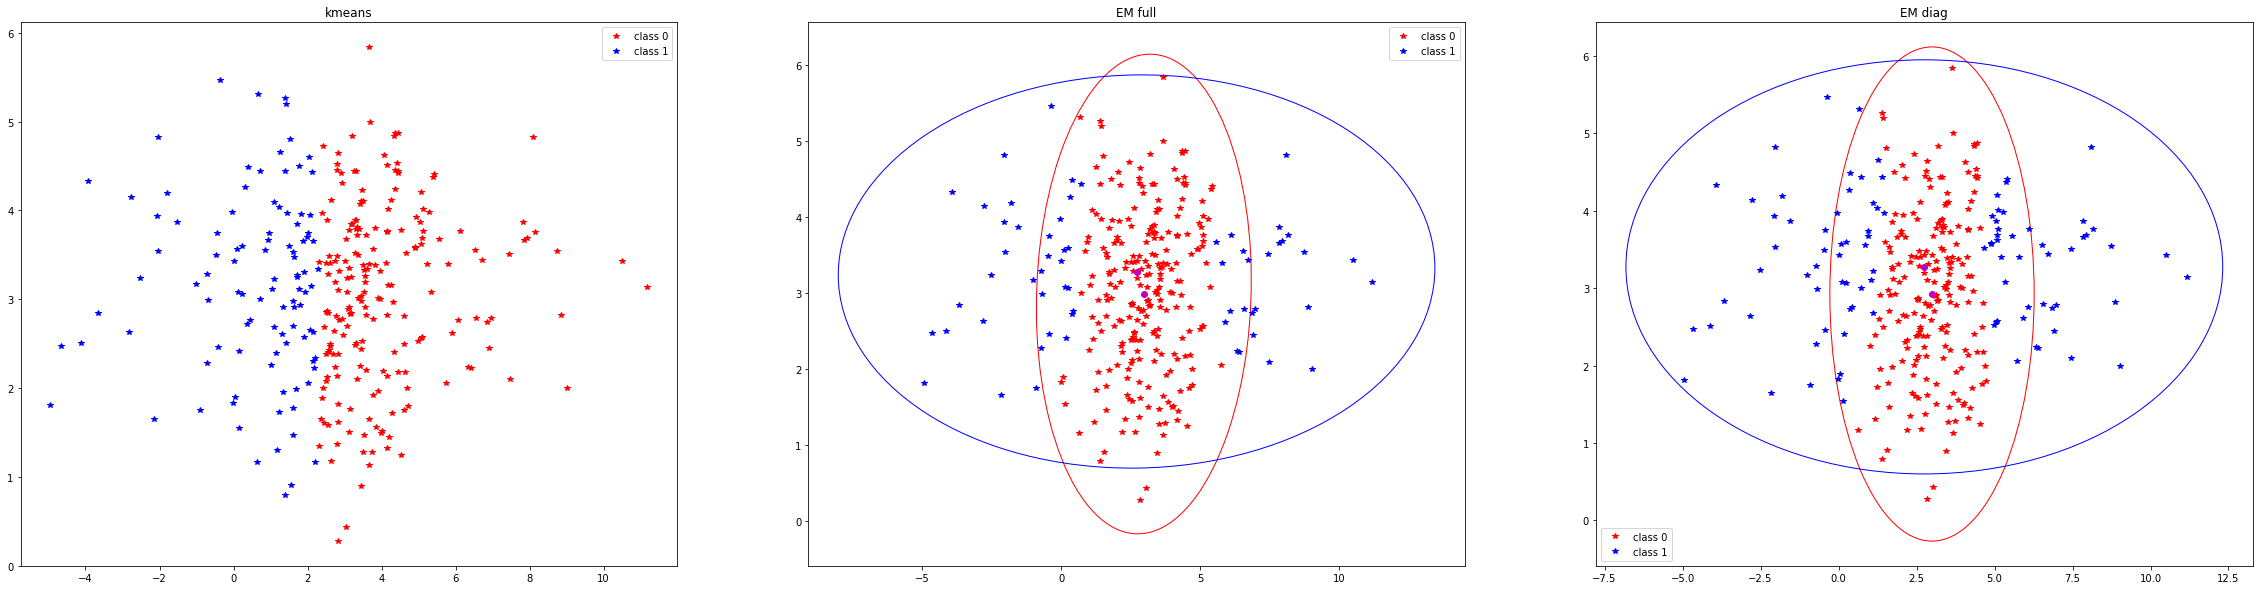

In [427]:
pred_plot(2,dataset)
plt.savefig('./synthetic2pred.eps',format='eps')

# Part II: Graphs, algorithms and Ising

## Sum-product for undirected chain

In [135]:
n = 10
alpha = 0
beta = 1

def psi_i(x):
    return np.exp(alpha*x)

def psi_ij(x_i,x_j,beta=1):
    return np.exp(beta*(x_i==x_j))

def compute_message(i,j,x,beta=1):
    assert np.abs(i-j)==1, 'not neighbors'
    message = 0
    for x_i in range(1):
        message += psi_i(x_i) * psi_ij(x_i,x[j],beta)
    return message

def msg_matrix(n,beta):
    """
    return:
    - msg : (4,n) matrix containing the messages.
    The first two lines contain messages received from the left.
    The next two lines contain messages received from the right.
    (One line is for value 0, the other is for value 1)
    ex : msg[2,5] is mu_{6->5}(x_5=0). 
    Message received by node 5 from the right evaluated in 0.
    """
    
    msg = np.zeros((4,n))
    msg[:2,0],msg[2:,n-1] = 1,1
    # Compute messages from left
    for i in range(1,n):
        for x_i in range(2):
            for x_j in range(2):
                msg[x_i,i] += psi_i(x_j) * psi_ij(x_i,x_j) * msg[x_j,i-1]
    
    # Compute messages from right
    for i in range(n-2,-1,-1):
        for x_i in range(2):
            for x_j in range(2):
                msg[2+x_i,i] += psi_i(x_j) * psi_ij(x_i,x_j) * msg[2+x_j,i+1]
                
    #msg[:2,0],msg[2:,n-1] = None,None
    return msg



def p(x_i,i,msg,z):
    proba = psi_i(x_i) * msg[x_i,i] * msg[2+x_i,i]
    proba /= z
    return proba

def compute_z(msg):
    z = 0
    for x_0 in range(2):
        z += psi_i(x_0) * msg[2+x_0,0]
    return z

# Ising model

In [2]:
w = 10
h = 100
alpha = 0
beta = 1

In [24]:
def val_x(w):
    value_x = []
    for s in [bin(i)[2:] for i in range(2**w)]:
        x = []
        for c in s:
            x.append(int(c))
        x = [0]*(10-len(s)) + x
        value_x.append(np.array(x))
    return value_x

def psi_i(x):
    return 1 #alpha=0

def psi_ij(x_i,x_j,beta):
    return np.exp(beta*np.sum(x_i==x_j))

In [25]:
def msg_from_left(w, h, beta):
    """
    return:
    - msg from left
    """
    value_x = val_x(w)
    n_state = len(value_x)
    
    msg = np.zeros((n_state,h))
    msg[:,0] = 1
    
    
    # Compute messages from left
    for i in range(1,h):
        for x_i in value_x:
            for x_j in value_x:
                msg[x_i,i] += psi_i(x_j) * psi_ij(x_i,x_j, beta) * msg[x_j,i-1]
        if i%10==0:
            print(i)
            print(msg)
    
    return msg

In [144]:
w = 5
h = 5 
v, ps = val_x(w)

In [157]:
def val_x(w):
    value_x = []
    psi_i_list = np.zeros((2**w))
    for s in [bin(i)[2:] for i in range(2**w)]:
        x = []
        for c in s:
            x.append(int(c))
        x = [0]*(w-len(s)) + x
        value_x.append(np.array(x))
        
    for state, x in enumerate(value_x):
        for i in range(w-1):
            if x[i] == x[i+1]:
                psi_i_list[state] += 1
    return value_x, psi_i_list

def psi_i(x,alpha=0, log_scale=True):
    if log_scale:
        return alpha*np.sum(x)
    return np.exp(alpha*np.sum(x))


def psi_i(id_state, psi_i_list,beta, log_scale=True):
    if log_scale:
        return beta*psi_i_list[id_state]
    return np.exp(beta*psi_i_list[id_state])
    


def psi_ij(x_i,x_j,beta,log_scale=True):
    if log_scale:
        return beta*np.sum(x_i==x_j)
    return np.exp(beta*np.sum(x_i==x_j))

def LSE(x):
    x_max = np.max(x)
    return x_max + np.log(np.sum(np.exp(x-x_max)))

def log_sum_exp(x):
    return np.log(np.sum(np.exp(x)))
    
def msg_from_left_log(value_x, psi_i_list, h, beta):
    """
    return:
    - msg from left
    msg is saved in log_scale
    """
    n_state = len(value_x)
    
    msg = np.zeros((n_state,h))
    msg[:,0] = 0
    
    # Compute messages from left
    for i in range(1,h):
        for state, x_i in enumerate(value_x):
            exp_to_add = np.zeros((n_state,))
            for j, x_j in enumerate(value_x):
                exp_to_add[j] = psi_i(j,psi_i_list,beta) + psi_ij(x_i,x_j,beta) + msg[j,i-1]
            msg[state,i] = LSE(exp_to_add)

    return msg

def compute_log_z(psi_i_list,beta, log_msg):
    n_state = log_msg.shape[0]
    last_log_msg = log_msg[:,-1]
    list_log = np.zeros((n_state,))
    for id_state in range(n_state):
        list_log[id_state] = psi_i(id_state,psi_i_list,beta) + last_log_msg[id_state]
    return LSE(list_log)



In [ ]:
h = 100
w = 10
value_x,psi_i_list = val_x(w)
alpha = 0
all_log_Z = []
betas = [0.2*(i+1) for i in range(4)] + [1,2,3,4,5]


for beta in betas:
    log_m = msg_from_left_log(value_x, psi_i_list, h, beta)
    log_z = compute_log_z(psi_i_list,beta,log_m)
    print("Beta:",beta,'logz:', log_z)
    all_log_Z.append(log_z)


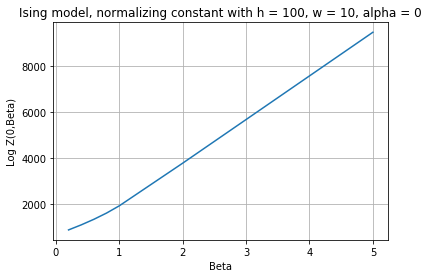

In [174]:
betas,all_log_Z = pickle.load(open('./q2betalogz.p','rb'))
plt.plot(betas, np.array(all_log_Z))
plt.ylabel('Log Z(0,Beta)')
plt.xlabel('Beta')
plt.title('Ising model, normalizing constant with h = 100, w = 10, alpha = 0')
plt.grid()
#plt.savefig('./figq2.eps',format='eps')
#p.dump([betas,all_log_Z], open('./q2betalogz.p','wb'))
